In [17]:
import torch
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from tqdm import tqdm

device = "cpu" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [18]:
#Loading model
import sys
import os
import torch
# Get the current script's directory
current_directory = os.getcwd()
print(current_directory)
library_directory = os.path.abspath(os.path.join(current_directory, 'torchVersion', 'BLIP'))
sys.path.append(library_directory)
from models.blip_vqa import blip_vqa

#model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_vqa_capfilt_large.pth'
model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_vqa.pth'

image_size = 480
model = blip_vqa(pretrained=model_url, image_size=image_size, vit='base')
model = model.to(device)
print(model)

e:\10mociclo\FoundationModels\Multiple-choice-VQA\FineTuningBLIP


**Dataset**

In [ ]:
import sys
sys.path.append('../')  # Adjust the path accordingly
from VQA_Dataset_BLIP import VQA_Dataset_preloaded_TorchVersion

dataset = VQA_Dataset_preloaded_TorchVersion(device)
dataset.compute_store(model.tokenizer, length=400, fileName="testing_gradcam.h5", real=False)

Preprocessing Images: 100%|██████████| 400/400 [00:14<00:00, 27.09it/s]


In [4]:
dataset.load(fileName="mscoco_testing_gradcam.h5")

**Test-train split**

In [5]:
def custom_collate_fn(batch):
    # 'batch' is a list of samples, each being a dictionary
    return batch

In [6]:
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np

train_size = int(len(dataset)*0.7)
val_size = int(len(dataset)*0.2)
test_size = int(len(dataset))-train_size-val_size
generator = torch.Generator().manual_seed(1)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)
print("Train size: ", train_size)
print("Test size: ", test_size)

batch_size=2
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

Train size:  280
Test size:  40


**Testing for one image**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


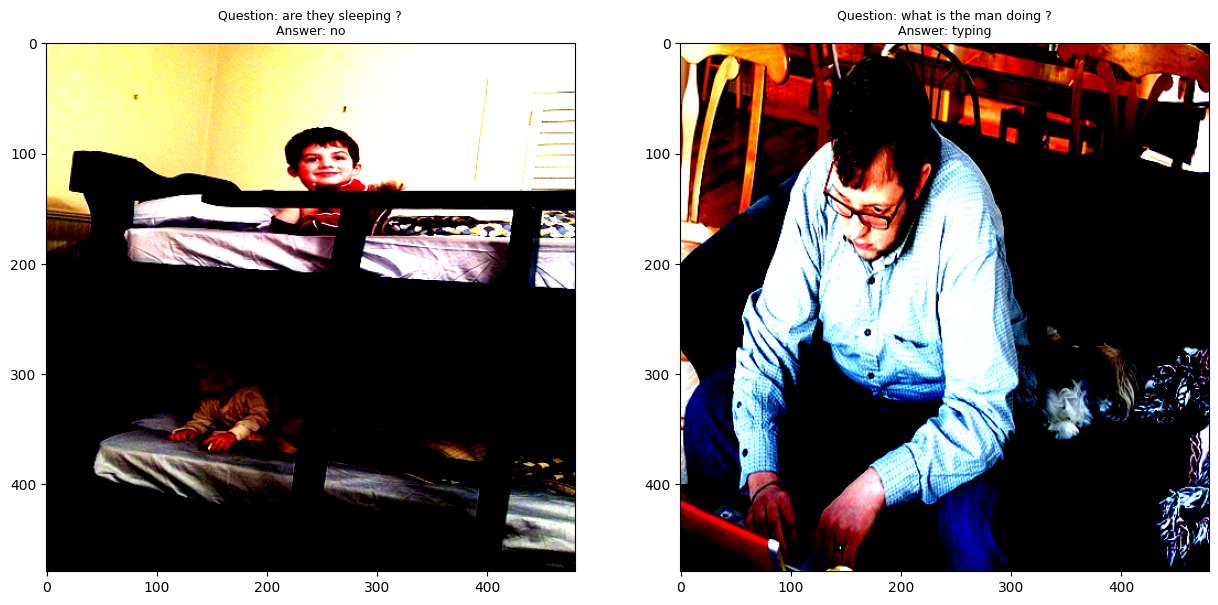

In [7]:
#Checking data
from utils import *
fig=plt.figure(0, (15, 28))
for num, element in enumerate(train_dataloader):
    if num==15:
        for i in range(batch_size):
            ax = fig.add_subplot(int(batch_size/2), 2,i+1)
            question_raw = element[i]["questions"]
            correct_answer_raw = element[i]["correct_answers"]
            multiple_answers = element[i]["multiple_answers"]
            question_text = convert_ids_to_string(question_raw["input_ids"].cpu(), model)
            correct_answer_text = convert_ids_to_string(correct_answer_raw["input_ids"].cpu(), model)
            img = element[i]["imgs"]
            ax.imshow(np.transpose(img.squeeze(0).cpu() , (1, 2, 0))) #Converting to matplotlib format
            ax.set_title("Question: "+question_text+"\nAnswer: "+correct_answer_text, fontsize=9)
        break

**Calculating grad and cams**

In [8]:
print(question_raw["input_ids"])
print(convert_ids_to_string(question_raw["input_ids"][0][6].unsqueeze(0).unsqueeze(0), model))

tensor([[30523,  2054,  2003,  1996,  2158,  2725,  1029,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]])
?


In [9]:
print(correct_answer_raw)
print(convert_string_to_ids("door", model))

{'input_ids': tensor([[30523, 22868,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}
{'input_ids': tensor([[30523,  2341,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}


In [10]:
'''
#Using feature maps and gradients from image encoder
model.eval()

model.visual_encoder.blocks[-1].attn.save_attention=True

#correct_answer_raw = convert_string_to_ids("window", model)

loss = model(img, question_raw, answer = correct_answer_raw, train=False, inference='gradcam')
print(loss)
model.zero_grad()
loss.backward()

mask = question_raw["attention_mask"].view(question_raw["attention_mask"].size(0),1,-1,1,1)
print("Mask: ", mask)

print(model.visual_encoder.blocks[-1].attn.get_attn_gradients())
grads=model.visual_encoder.blocks[-1].attn.get_attn_gradients()
cams=model.visual_encoder.blocks[-1].attn.get_attention_map()
print(cams.shape, grads.shape)

cams = cams[:, :, :, 1:].reshape(1, 12, -1, 40, 40)#cuz the feature maps are of lower dimension than original image
grads = grads[:, :, :, 1:].clamp(0).reshape(1, 12, -1, 40, 40)#12 because there are n blocks in text 
print(cams.shape, grads.shape)

cams *= mask
grads *= mask

print(cams.shape, grads.shape)

gradcam = cams * grads
gradcam = gradcam[0].mean(0).cpu().detach()
print("gradcam shape: ", gradcam.shape)
'''

'\n#Using feature maps and gradients from image encoder\nmodel.eval()\n\nmodel.visual_encoder.blocks[-1].attn.save_attention=True\n\n#correct_answer_raw = convert_string_to_ids("window", model)\n\nloss = model(img, question_raw, answer = correct_answer_raw, train=False, inference=\'gradcam\')\nprint(loss)\nmodel.zero_grad()\nloss.backward()\n\nmask = question_raw["attention_mask"].view(question_raw["attention_mask"].size(0),1,-1,1,1)\nprint("Mask: ", mask)\n\nprint(model.visual_encoder.blocks[-1].attn.get_attn_gradients())\ngrads=model.visual_encoder.blocks[-1].attn.get_attn_gradients()\ncams=model.visual_encoder.blocks[-1].attn.get_attention_map()\nprint(cams.shape, grads.shape)\n\ncams = cams[:, :, :, 1:].reshape(1, 12, -1, 40, 40)#cuz the feature maps are of lower dimension than original image\ngrads = grads[:, :, :, 1:].clamp(0).reshape(1, 12, -1, 40, 40)#12 because there are n blocks in text \nprint(cams.shape, grads.shape)\n\ncams *= mask\ngrads *= mask\n\nprint(cams.shape, grads

In [11]:
'''from pytorch_grad_cam import GradCAM
import cv2
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1 :  , :].reshape(tensor.size(0),
        height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    print(result.shape)
    return result

rgb_img = np.float32(np.transpose(img.squeeze(0).cpu() , (1, 2, 0)))
print(rgb_img.shape)
input_tensor = preprocess_image(rgb_img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
print(input_tensor.shape)
model.eval()

target_layers = [model.visual_encoder.blocks[-1].norm1]
gradcam = GradCAM(model=model.visual_encoder, target_layers=target_layers, reshape_transform=reshape_transform)
gradcam.batch_size = 32
targets = None
print(img.shape)
grayscale_cam = gradcam(input_tensor=input_tensor, targets=targets)
'''

'from pytorch_grad_cam import GradCAM\nimport cv2\nfrom pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image\ndef reshape_transform(tensor, height=14, width=14):\n    result = tensor[:, 1 :  , :].reshape(tensor.size(0),\n        height, width, tensor.size(2))\n\n    # Bring the channels to the first dimension,\n    # like in CNNs.\n    result = result.transpose(2, 3).transpose(1, 2)\n    print(result.shape)\n    return result\n\nrgb_img = np.float32(np.transpose(img.squeeze(0).cpu() , (1, 2, 0)))\nprint(rgb_img.shape)\ninput_tensor = preprocess_image(rgb_img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])\nprint(input_tensor.shape)\nmodel.eval()\n\ntarget_layers = [model.visual_encoder.blocks[-1].norm1]\ngradcam = GradCAM(model=model.visual_encoder, target_layers=target_layers, reshape_transform=reshape_transform)\ngradcam.batch_size = 32\ntargets = None\nprint(img.shape)\ngrayscale_cam = gradcam(input_tensor=input_tensor, targets=targets)\n'

In [12]:
#Using feature maps and gradients from image grounded text encoder
model.eval()

block_num = 8#Number from 0 to 11
model.text_encoder.base_model.base_model.encoder.layer[block_num].crossattention.self.save_attention = True

#correct_answer_raw = convert_string_to_ids("yes", model)

loss = model(img, question_raw, answer = correct_answer_raw, train=False, inference='gradcam')
print(loss)
model.zero_grad()
loss.backward()

mask = question_raw["attention_mask"].view(question_raw["attention_mask"].size(0),1,-1,1,1)
print("Mask: ", mask)

grads=model.text_encoder.base_model.base_model.encoder.layer[block_num].crossattention.self.get_attn_gradients()
cams=model.text_encoder.base_model.base_model.encoder.layer[block_num].crossattention.self.get_attention_map()
print(cams.shape, grads.shape)

cams = cams[:, :, :, 1:].reshape(1, 12, -1, 30, 30)#cuz the feature maps are of lower dimension than original image
grads = grads[:, :, :, 1:].clamp(0).reshape(1, 12, -1, 30, 30)#12 because there are n blocks in text 
print(cams.shape, grads.shape)

cams *= mask
grads *= mask

print(cams.shape, grads.shape)

gradcam = cams * grads
gradcam = gradcam[0].mean(0).cpu().detach()#Average over all attention heads
print("gradcam shape: ", gradcam.shape)

tensor([4.1176], grad_fn=<SumBackward1>)
Mask:  tensor([[[[[1]],

          [[1]],

          [[1]],

          [[1]],

          [[1]],

          [[1]],

          [[1]],

          [[1]],

          [[0]],

          [[0]],

          [[0]],

          [[0]],

          [[0]],

          [[0]],

          [[0]],

          [[0]],

          [[0]],

          [[0]],

          [[0]],

          [[0]]]]])
torch.Size([1, 12, 20, 901]) torch.Size([1, 12, 20, 901])
torch.Size([1, 12, 20, 30, 30]) torch.Size([1, 12, 20, 30, 30])
torch.Size([1, 12, 20, 30, 30]) torch.Size([1, 12, 20, 30, 30])
gradcam shape:  torch.Size([20, 30, 30])


**Predicting output**

In [13]:
idx = model(img, question_raw, answer = multiple_answers, train=False, inference='rank_compressed', k_test=18).item()
predicted_answer = multiple_answers["input_ids"][idx]
predicted_answer[0] = 30523
predicted_answer_text = convert_ids_to_string(predicted_answer.unsqueeze(0), model)

**Visualizing gradcam**

In [14]:
import cv2
import numpy as np

from skimage import transform as skimage_transform
from scipy.ndimage import filters
from matplotlib import pyplot as plt

def getAttMap(img, attMap, blur = True, overlap = True):
    attMap -= attMap.min()
    if attMap.max() > 0:
        attMap /= attMap.max()
    attMap = skimage_transform.resize(attMap, (img.shape[:2]), order = 3, mode = 'constant')
    if blur:
        attMap = filters.gaussian_filter(attMap, 0.04*max(img.shape[:2]))
        attMap -= attMap.min()
        attMap /= attMap.max()
    cmap = plt.get_cmap('jet')
    attMapV = cmap(attMap)
    attMapV = np.delete(attMapV, 3, 2)
    if overlap:
        attMap = 1*(1-attMap**0.3).reshape(attMap.shape + (1,))*img + (attMap**0.7).reshape(attMap.shape+(1,)) * attMapV
    return attMap

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Gradcam Attention Maps\nPredicted answer: typing')

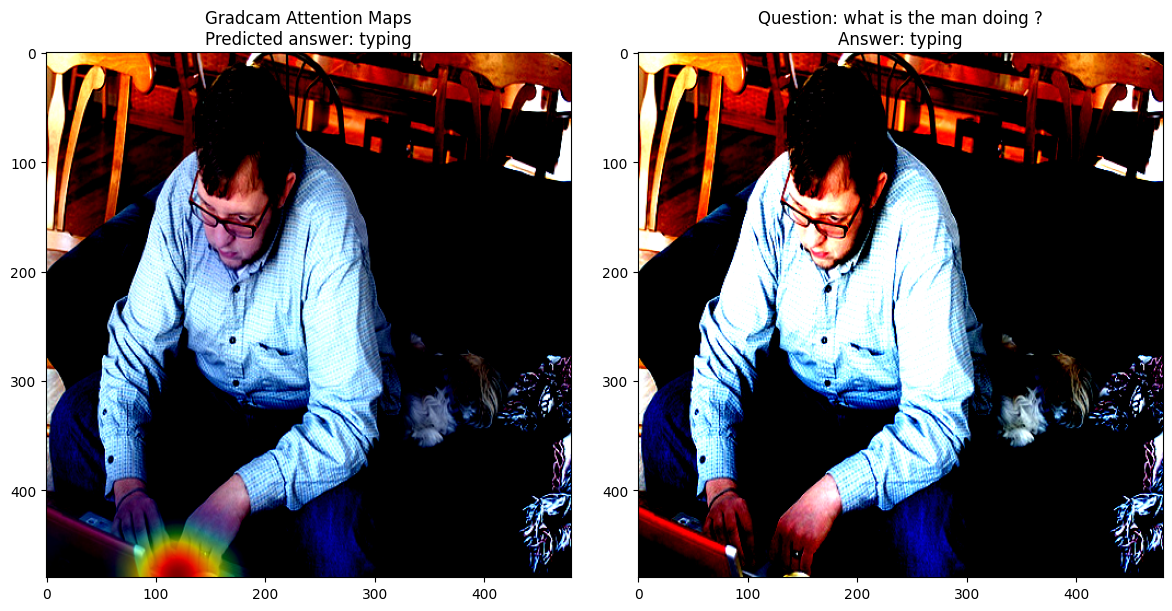

In [15]:
from PIL import Image

fig=plt.figure(0, (28, 15))
ax = fig.add_subplot(2,1,1)
img_for_att = np.float32(np.transpose(img.squeeze(0).cpu() , (1, 2, 0)))

ax.imshow(img_for_att) #Converting to matplotlib format
ax.set_title("Question: "+str(question_text)+"\nAnswer: "+correct_answer_text)

ax = fig.add_subplot(2,2,1)

gradcam_image = getAttMap(img_for_att, gradcam[1:].mean(0), overlap=True, blur=True)
#ax.axis("off")
ax.imshow(gradcam_image) #Converting to matplotlib format
ax.set_title("Gradcam Attention Maps\nPredicted answer: "+str(predicted_answer_text))
#ax.set_title("Question: "+str(question_text)+"\nAnswer: "+correct_answer_text)

In [16]:
multiple_answers["input_ids"].shape
[convert_ids_to_string(mc.unsqueeze(0).cpu(), model) for mc in multiple_answers["input_ids"]]

['no',
 '4',
 '2',
 'mowing lawn',
 'white',
 'sombrero',
 'blue',
 'peppers , sausage , spinach , cheese',
 'eating',
 'green',
 'yes',
 'coughing',
 '1',
 'many',
 'red',
 '3',
 'swirl',
 'typing']